#### Import Libraries

In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [44]:
# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download BTC crypto data from Yahoo Finance using ticker 'BTC-USD'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

df_coin


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
Date,,,,,,,,
2021-04-14,381.000000,429.540009,310.000000,328.279999,328.279999,81065700,1734.900024,91.690002
2021-04-15,348.899994,349.200012,317.269989,322.750000,322.750000,39777900,1765.400024,91.669998
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998
...,...,...,...,...,...,...,...,...
2024-06-21,227.000000,228.250000,220.710007,225.860001,225.860001,11385800,2316.399902,105.800003
2024-06-24,217.220001,221.440002,207.710007,212.309998,212.309998,10762000,2330.000000,105.470001
2024-06-25,217.000000,222.880005,213.220001,221.710007,221.710007,8067100,2316.600098,105.610001


In [45]:
# Check for null values
df_coin.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Gold_Adj_Close       0
USIndex_Adj_Close    0
dtype: int64

In [46]:
# Check for duplicate indices
df_coin.index.duplicated(keep=False).sum()

0

In [47]:
# Stats for data
df_coin.describe()

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
count,807.000000,807.000000,807.000000,807.000000,807.000000,8.070000e+02,807.000000,807.000000
mean,148.006617,152.732506,143.272800,147.828625,147.828625,1.112285e+07,1906.489092,101.408893
std,88.772063,90.709660,86.425870,88.349040,88.349040,8.499929e+06,165.208225,5.579124
min,32.580002,33.480000,31.549999,32.529999,32.529999,1.574700e+06,1623.300049,89.639999
25%,66.770000,69.609997,63.465000,66.770000,66.770000,5.423050e+06,1792.549988,96.305000
50%,124.339996,128.889999,119.699997,124.190002,124.190002,9.339300e+06,1871.599976,103.160004
75%,231.595001,238.574997,226.584999,232.015007,232.015007,1.405680e+07,1979.000000,105.024998
max,381.000000,429.540009,345.559998,357.390015,357.390015,8.106570e+07,2433.899902,114.110001


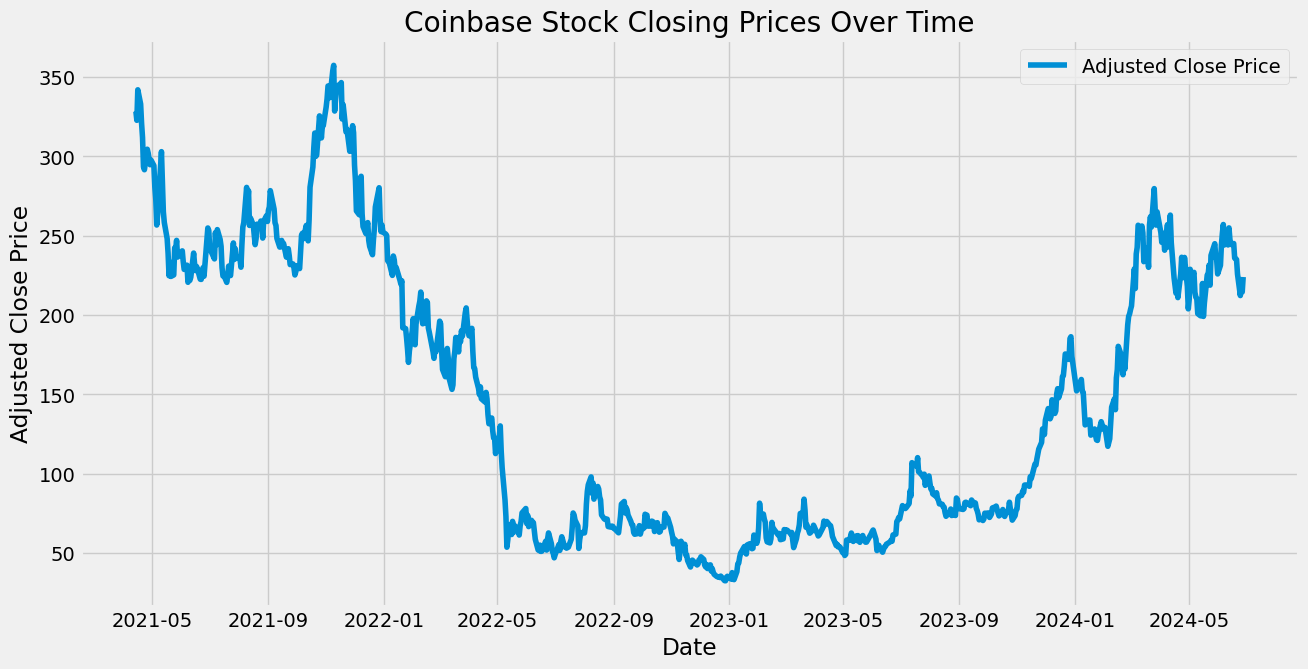

In [48]:
# Theme for plots
plt.style.use('fivethirtyeight')

# Plotting the Adjusted Close price to show the trend
plt.figure(figsize=(14, 7))
plt.plot(df_coin.index, df_coin['Adj Close'], label='Adjusted Close Price')
plt.title('Coinbase Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Calculate differences between high and low prices for the stock data
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])

df_coin['Log_Pct_Returns_1'] = df_coin['Log_Pct_Returns'].shift(1)
df_coin.dropna(inplace=True)
df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,Log_Pct_Returns,Log_Pct_Returns_1
Date,,,,,,,,,,,,
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998,24.959991,0.059644,0.057933,-0.016989
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000,14.220001,-0.026316,-0.026668,0.057933
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,22.809998,-0.036577,-0.037262,-0.026668
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,25.369995,-0.027741,-0.028133,-0.037262
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,26.299988,-0.059214,-0.061039,-0.028133
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,227.000000,228.250000,220.710007,225.860001,225.860001,11385800,2316.399902,105.800003,7.539993,-0.039016,-0.039798,-0.003907
2024-06-24,217.220001,221.440002,207.710007,212.309998,212.309998,10762000,2330.000000,105.470001,13.729996,-0.059993,-0.061868,-0.039798
2024-06-25,217.000000,222.880005,213.220001,221.710007,221.710007,8067100,2316.600098,105.610001,9.660004,0.044275,0.043323,-0.061868


##### Technical Indicators

In [50]:
# Moving Averages

# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()
df_coin['SMA_100'] = df_coin['Adj Close'].rolling(window=100).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,BB_Lower,14-high,14-low,%K,%D,H-L,H-PC,L-PC,TR,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998,24.959991,0.059644,...,NaN,NaN,NaN,NaN,NaN,24.959991,NaN,NaN,24.959991,NaN
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000,14.220001,-0.026316,...,NaN,NaN,NaN,NaN,NaN,14.220001,0.989990,15.209991,15.209991,NaN
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,22.809998,-0.036577,...,NaN,NaN,NaN,NaN,NaN,22.809998,1.829987,20.980011,22.809998,NaN
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,25.369995,-0.027741,...,NaN,NaN,NaN,NaN,NaN,25.369995,6.649994,18.720001,25.369995,NaN
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,26.299988,-0.059214,...,NaN,NaN,NaN,NaN,NaN,26.299988,1.579987,24.720001,26.299988,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-21,227.000000,228.250000,220.710007,225.860001,225.860001,11385800,2316.399902,105.800003,7.539993,-0.039016,...,220.383520,263.799988,220.710007,11.951720,28.362133,7.539993,6.779999,14.319992,14.319992,14.580714
2024-06-24,217.220001,221.440002,207.710007,212.309998,212.309998,10762000,2330.000000,105.470001,13.729996,-0.059993,...,218.425520,263.799988,207.710007,8.201092,18.563152,13.729996,4.419998,18.149994,18.149994,14.840714
2024-06-25,217.000000,222.880005,213.220001,221.710007,221.710007,8067100,2316.600098,105.610001,9.660004,0.044275,...,216.122545,263.799988,207.710007,24.959894,15.037569,9.660004,10.570007,0.910004,10.570007,14.378572


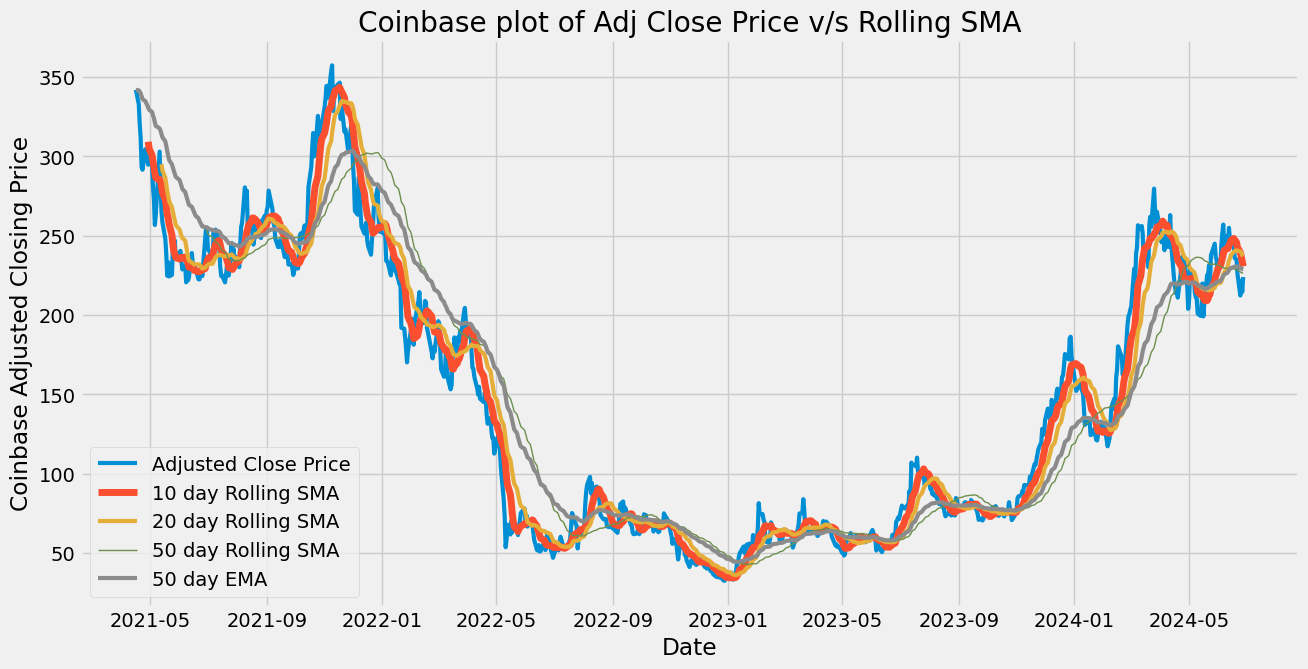

In [51]:
#Plotting 'Adj Close' Price and Rolling SMA and EMA lines
plt.figure(figsize = (14,7))
plt.plot(df_coin['Adj Close'],label='Adjusted Close Price',linewidth=3)
plt.plot(df_coin['SMA_10'],label='10 day Rolling SMA',linewidth=5)
plt.plot(df_coin['SMA_20'],label='20 day Rolling SMA',linewidth=3)
plt.plot(df_coin['SMA_50'],label='50 day Rolling SMA',linewidth=1)
plt.plot(df_coin['EMA_50'],label='50 day EMA',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Coinbase Adjusted Closing Price')
plt.title('Coinbase plot of Adj Close Price v/s Rolling SMA')
plt.legend()

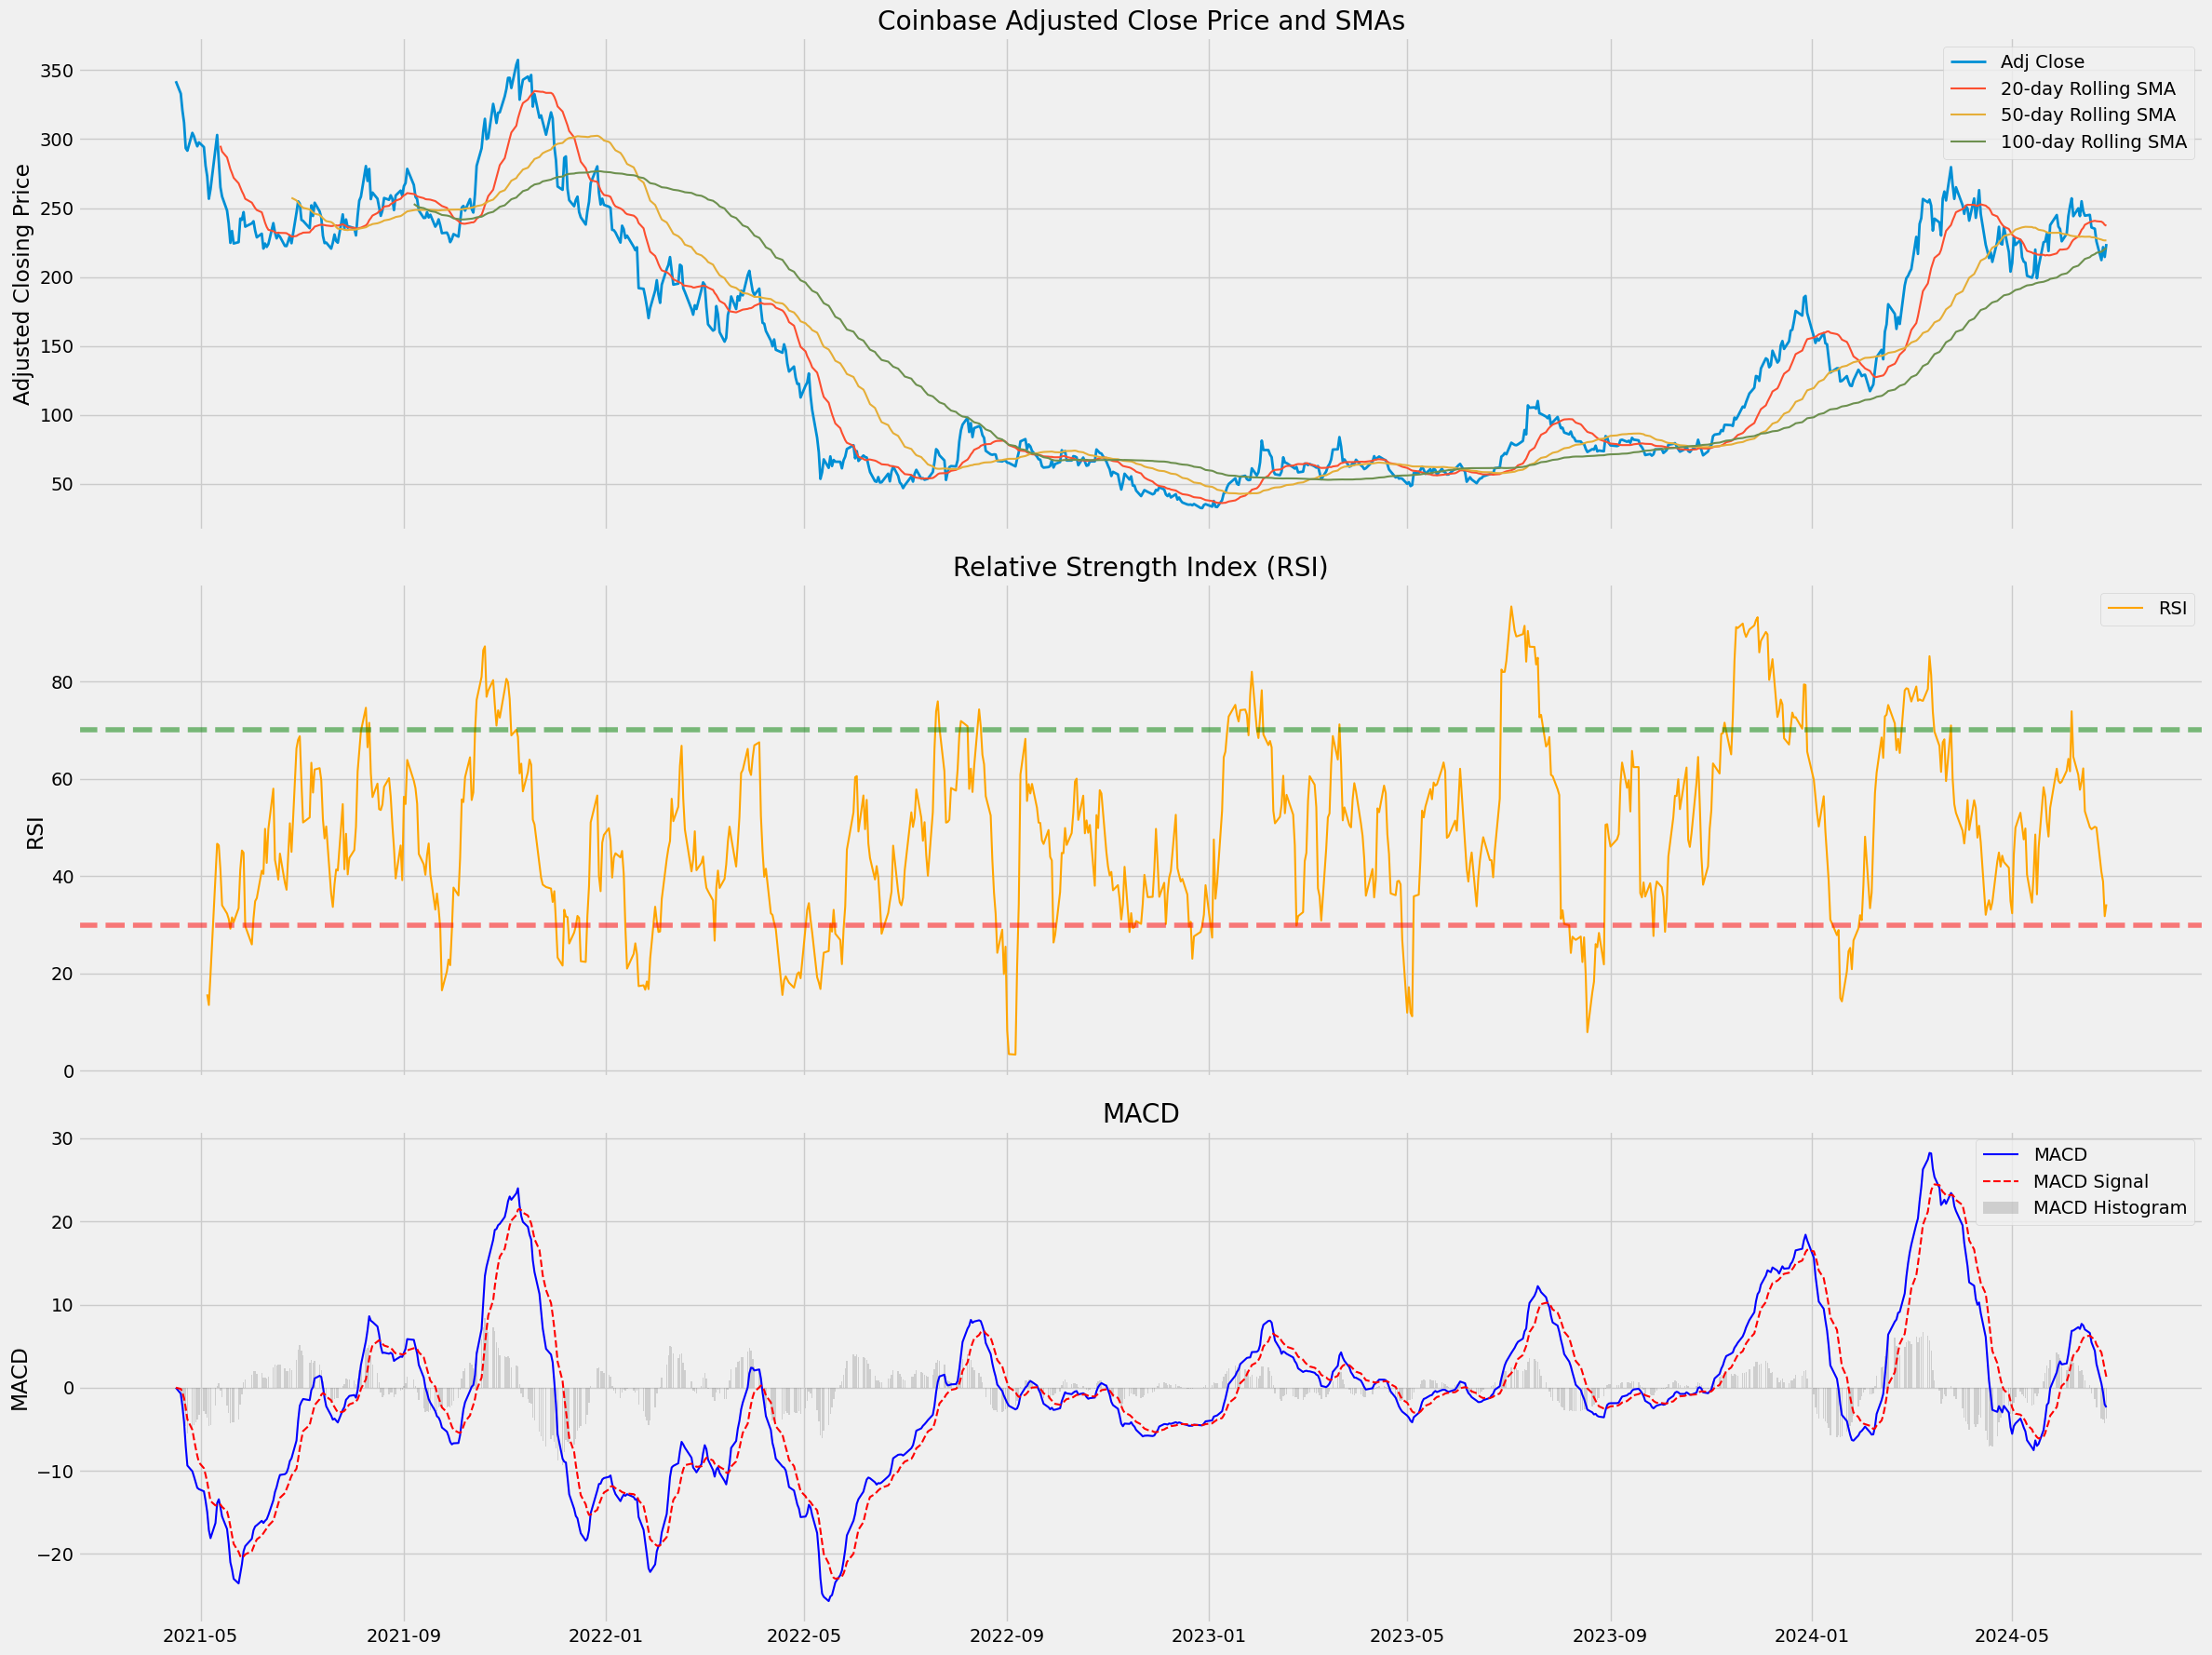

In [52]:
# Plotting Moving averages, RSI and  MACD signal
# to get comprehensive view of Coinbase price trends, volatility, and potential market reversal points

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 18), sharex=True)

# Plotting 'Adj Close' Price vs SMA lines on the first subplot
ax1.plot(df_coin['Adj Close'], label='Adj Close', linewidth=2)
ax1.plot(df_coin['SMA_20'], label='20-day Rolling SMA', linewidth=1.5)
ax1.plot(df_coin['SMA_50'], label='50-day Rolling SMA', linewidth=1.5)
ax1.plot(df_coin['SMA_100'], label='100-day Rolling SMA', linewidth=1.5)
ax1.set_title('Coinbase Adjusted Close Price and SMAs')
ax1.set_ylabel('Adjusted Closing Price')
ax1.legend()

# Plotting RSI on the second subplot
ax2.plot(df_coin['RSI'], label='RSI', color='orange', linewidth=1.5)
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='green')
ax2.legend()

# Plotting MACD on the third subplot
ax3.plot(df_coin['MACD'], label='MACD', color='blue', linewidth=1.5)
ax3.plot(df_coin['MACD_Signal'], label='MACD Signal', color='red', linestyle='--', linewidth=1.5)
ax3.bar(df_coin.index, df_coin['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.3)
ax3.set_title('MACD')
ax3.set_ylabel('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

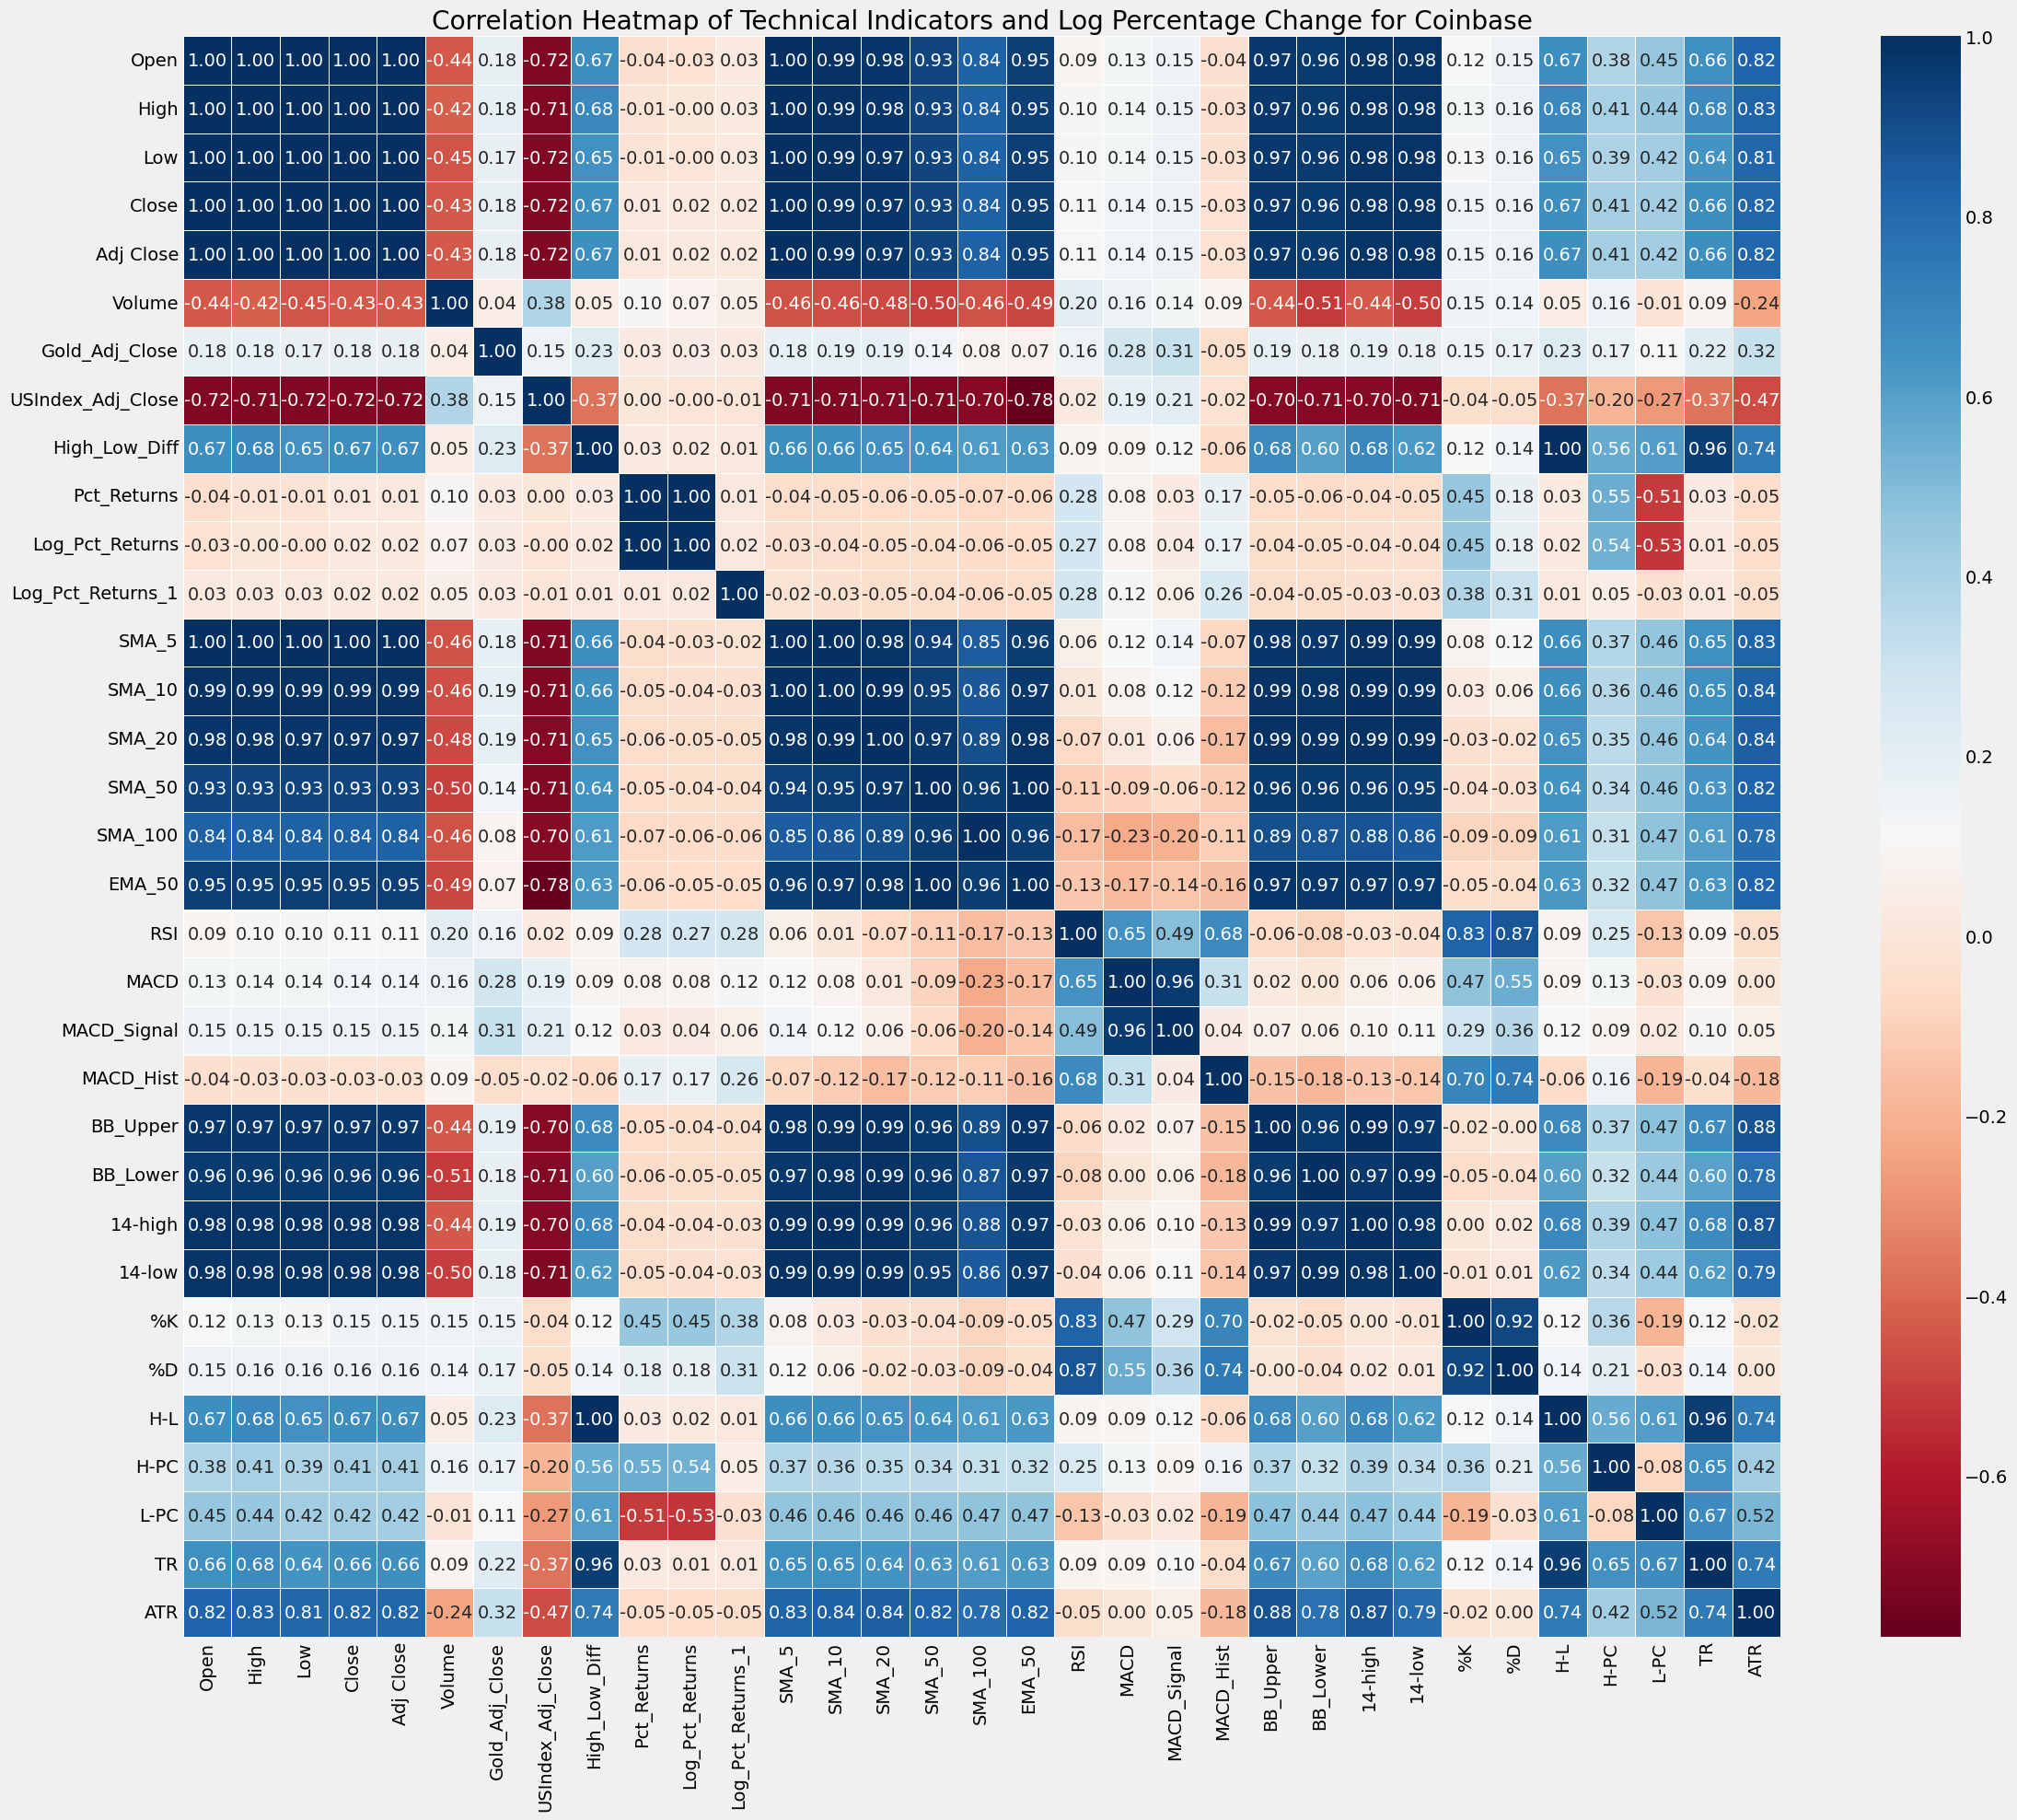

In [53]:
# Correlation between technical indiactors and log percentage change
# Compute correlation matrix
corr_matrix = df_coin.corr()

# Create a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Technical Indicators and Log Percentage Change for Coinbase')
plt.tight_layout()
plt.show()

#### Economic Indicators

In [54]:
# Fetch Real disposable Income data(Monthly) from FRED using pandas_datareader
Real_Disp_Inc_Mon = pdr.get_data_fred('DSPIC96', start=start_date, end=end_date)
Real_Disp_Inc_df = Real_Disp_Inc_Mon.resample('D').ffill()
Real_Disp_Inc_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Real_Disp_Inc_df.index = pd.to_datetime(Real_Disp_Inc_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Real_Disp_Inc_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)
merged_df


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,TR,ATR,DSPIC96,FEDFUNDS,GDPC1,UNRATE,UMCSENT,CPILFESL,PPIACO,WM2NS
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-07,277.000000,278.869995,262.600006,266.809998,266.809998,5173000,1795.900024,92.519997,16.269989,-0.041768,...,16.269989,10.239284,16564.3,0.08,21483.083,4.7,72.8,279.710,235.678,20925.4
2021-09-08,257.000000,262.950012,253.880005,258.200012,258.200012,4507600,1790.699951,92.650002,9.070007,-0.032270,...,12.929993,10.402855,16564.3,0.08,21483.083,4.7,72.8,279.710,235.678,20925.4
2021-09-09,260.299988,263.809998,255.699997,256.420013,256.420013,3074500,1797.400024,92.480003,8.110001,-0.006894,...,8.110001,10.226426,16564.3,0.08,21483.083,4.7,72.8,279.710,235.678,20925.4
2021-09-10,257.309998,258.869995,247.399994,248.320007,248.320007,3191300,1789.599976,92.580002,11.470001,-0.031589,...,11.470001,10.161427,16564.3,0.08,21483.083,4.7,72.8,279.710,235.678,20925.4
2021-09-13,246.509995,251.880005,239.600006,242.839996,242.839996,4021400,1792.000000,92.620003,12.279999,-0.022068,...,12.279999,10.217141,16564.3,0.08,21483.083,4.7,72.8,279.710,235.678,20970.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,10.800003,0.044337,...,10.800003,9.122142,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20875.3
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,9.069992,-0.019546,...,9.069992,9.149998,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,11.470001,0.076664,...,14.919998,9.549998,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


In [55]:
# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Low', 'Volume',
    'High_Low_Diff', 'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR',
    'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
    'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS'
]

# Number of lagged versions to create
num_lags = 3

# Dictionary to store the shifted columns
shifted_columns = {}

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):  
        shifted_columns[f'{column}_{lag}'] = merged_df[column].shift(lag)

# Create a DataFrame from the shifted columns
shifted_df = pd.DataFrame(shifted_columns)

# Concatenate the shifted columns to the original DataFrame
merged_df = pd.concat([merged_df, shifted_df], axis=1)

# Drop rows with any NaN values
merged_df.dropna(inplace=True)

merged_df

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,UMCSENT_3,CPILFESL_1,CPILFESL_2,CPILFESL_3,PPIACO_1,PPIACO_2,PPIACO_3,WM2NS_1,WM2NS_2,WM2NS_3
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-10,257.309998,258.869995,247.399994,248.320007,248.320007,3191300,1789.599976,92.580002,11.470001,-0.031589,...,72.8,279.710,279.710,279.710,235.678,235.678,235.678,20925.4,20925.4,20925.4
2021-09-13,246.509995,251.880005,239.600006,242.839996,242.839996,4021400,1792.000000,92.620003,12.279999,-0.022068,...,72.8,279.710,279.710,279.710,235.678,235.678,235.678,20925.4,20925.4,20925.4
2021-09-14,247.250000,248.789993,241.270004,243.000000,243.000000,2748900,1804.699951,92.650002,7.519989,0.000659,...,72.8,279.710,279.710,279.710,235.678,235.678,235.678,20970.2,20925.4,20925.4
2021-09-15,244.000000,249.470001,242.050003,247.070007,247.070007,2148300,1792.400024,92.489998,7.419998,0.016749,...,72.8,279.710,279.710,279.710,235.678,235.678,235.678,20970.2,20970.2,20925.4
2021-09-16,247.380005,247.460007,239.610001,243.210007,243.210007,2596800,1754.599976,92.860001,7.850006,-0.015623,...,72.8,279.710,279.710,279.710,235.678,235.678,235.678,20970.2,20970.2,20970.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,10.800003,0.044337,...,69.7,313.209,313.209,313.209,249.866,249.866,249.866,20875.3,20875.3,20875.3
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,9.069992,-0.019546,...,69.7,313.209,313.209,313.209,249.866,249.866,249.866,20875.3,20875.3,20875.3
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,11.470001,0.076664,...,69.7,313.209,313.209,313.209,249.866,249.866,249.866,20901.5,20875.3,20875.3


#### Fitting Models with all features

In [56]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Define models to evaluate
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('model', model)            
    ])
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    # Store results in dictionary
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Linear:
Training MSE: 0.0005 (Std Dev: 0.0003)
Test MSE: 1.0124 (Std Dev: 3.0208)
Training RMSE: 0.0199 (Std Dev: 0.0108)
Test RMSE: 0.3733 (Std Dev: 0.9344)
Training MAE: 0.0148 (Std Dev: 0.0080)
Test MAE: 0.3306 (Std Dev: 0.8401)
Training R2: 0.8680 (Std Dev: 0.0789)
Test R2: -109.0644 (Std Dev: 323.8232)

Lasso:
Training MSE: 0.0032 (Std Dev: 0.0011)
Test MSE: 0.0038 (Std Dev: 0.0023)
Training RMSE: 0.0553 (Std Dev: 0.0115)
Test RMSE: 0.0594 (Std Dev: 0.0177)
Training MAE: 0.0418 (Std Dev: 0.0080)
Test MAE: 0.0464 (Std Dev: 0.0144)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0463 (Std Dev: 0.0827)

Ridge:
Training MSE: 0.0011 (Std Dev: 0.0004)
Test MSE: 0.0020 (Std Dev: 0.0016)
Training RMSE: 0.0316 (Std Dev: 0.0074)
Test RMSE: 0.0423 (Std Dev: 0.0153)
Training MAE: 0.0216 (Std Dev: 0.0043)
Test MAE: 0.0316 (Std Dev: 0.0112)
Training R2: 0.6777 (Std Dev: 0.0293)
Test R2: 0.4532 (Std Dev: 0.2074)

Random Forest:
Training MSE: 0.0002 (Std Dev: 0.0000)
Test MSE: 0.0020 (Std Dev:

#### Hypertuning Ridge Regression Model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.12978e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.91768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.22457e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training MSE: 0.0008
Training MSE Std Dev: 0.0005
Test MSE: 0.0013
Test MSE Std Dev: 0.0013
Training RMSE: 0.0252
Training RMSE Std Dev: 0.0123
Test RMSE: 0.0324
Test RMSE Std Dev: 0.0165
Training MAE: 0.0186
Training MAE Std Dev: 0.0092
Test MAE: 0.0255
Test MAE Std Dev: 0.0134
Training R2: 0.7942
Training R2 Std Dev: 0.1144
Test R2: 0.7129
Test R2 Std Dev: 0.1190


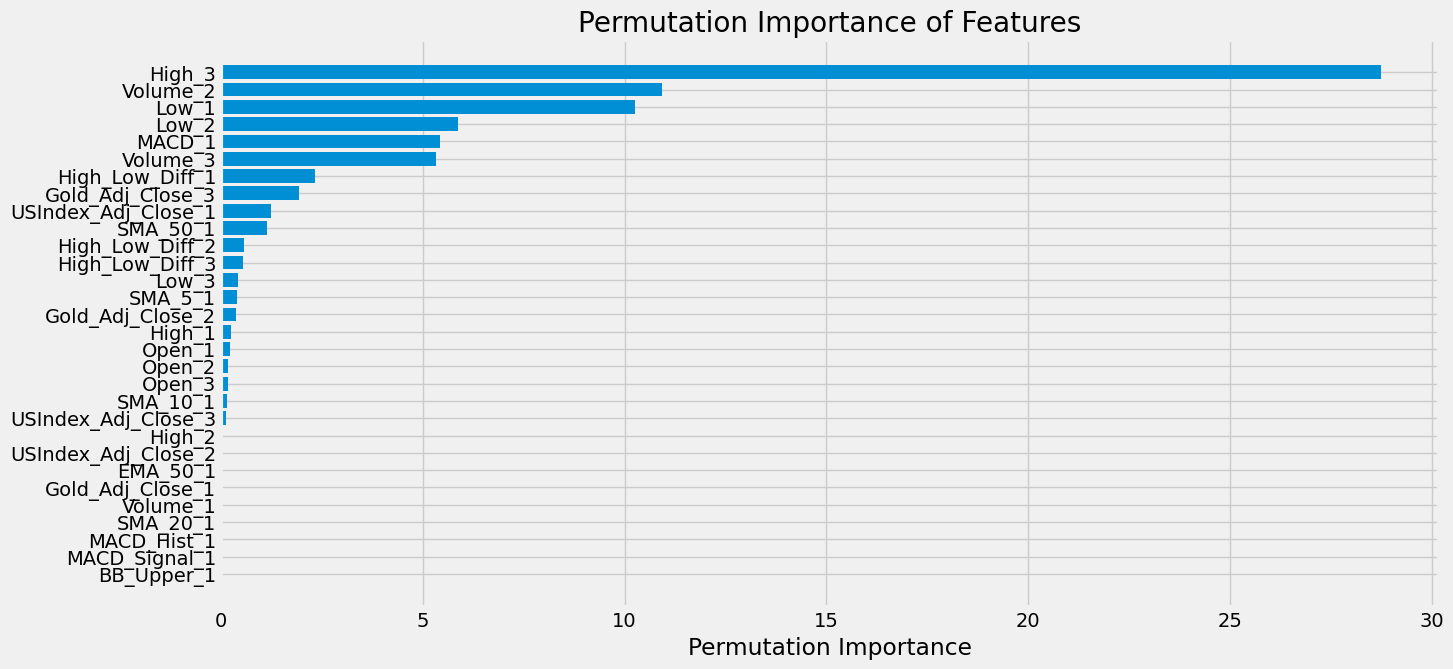

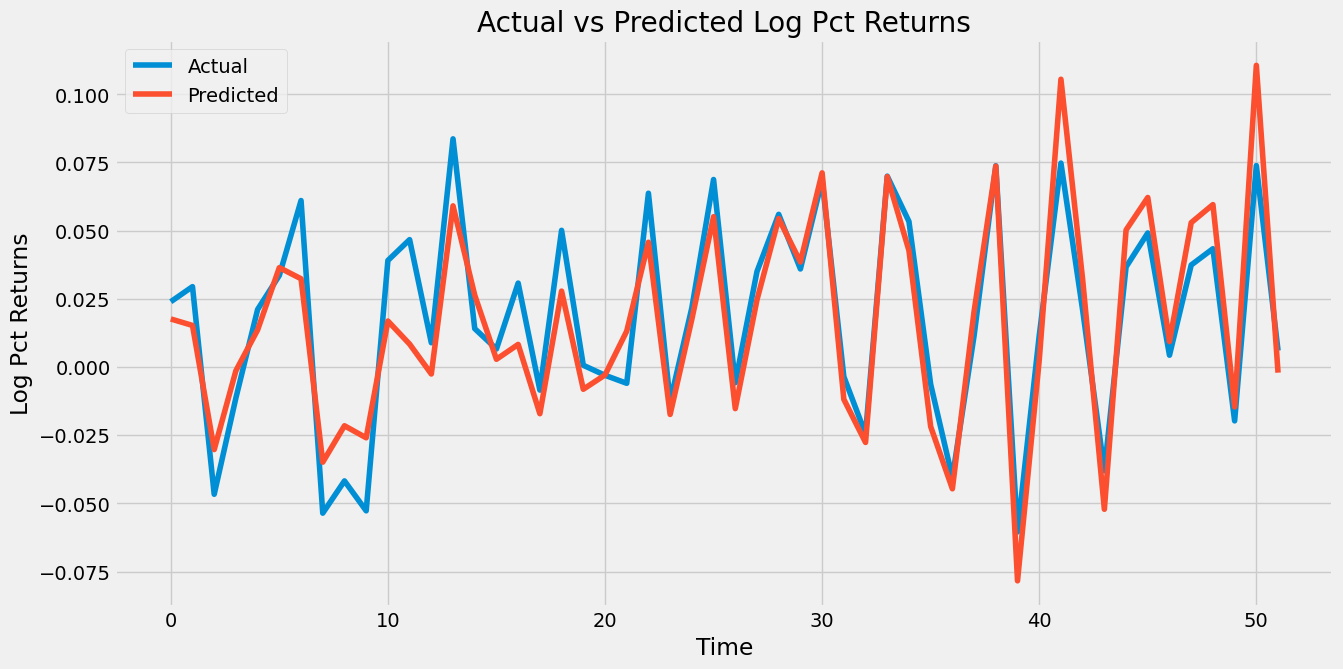

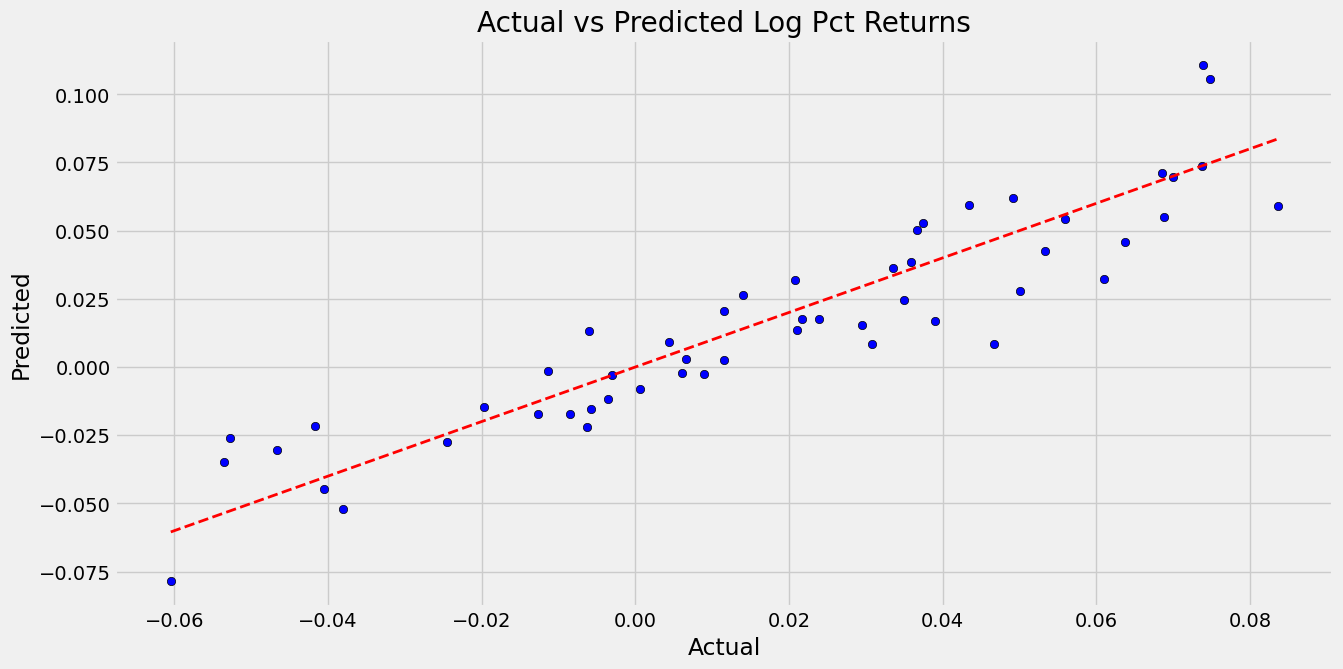

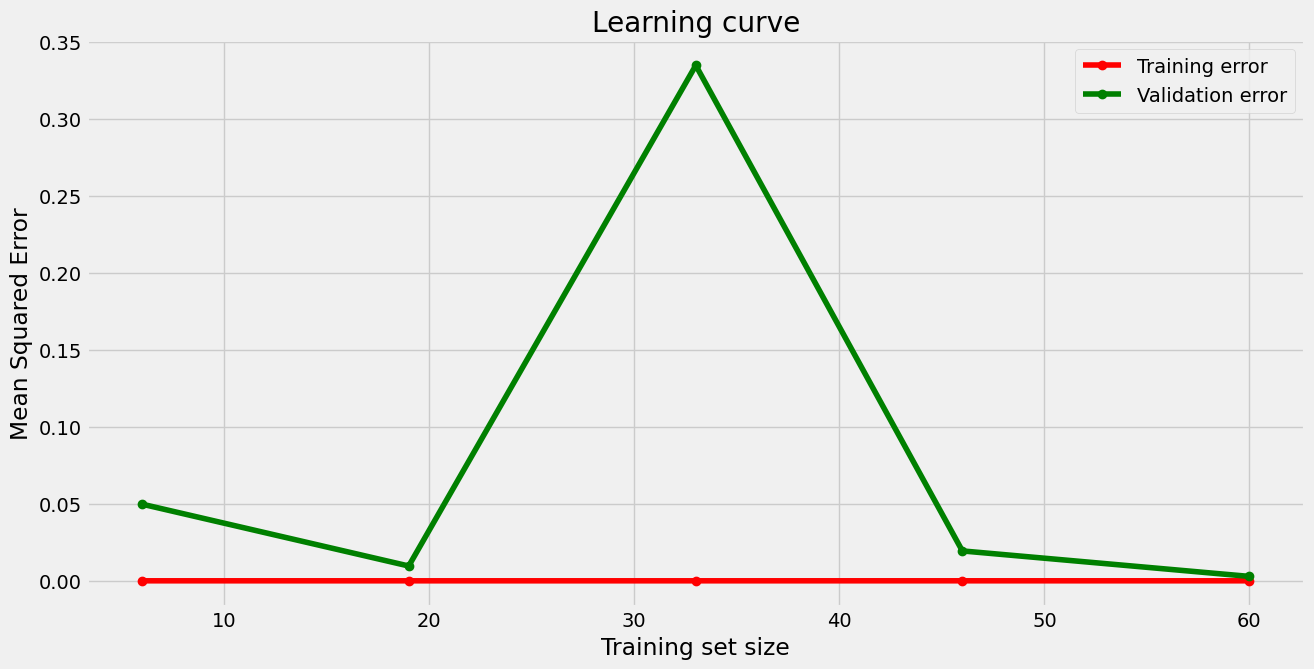

In [63]:
# Seed for reproducibility
np.random.seed(42)

# Feature list
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_1', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1'
            ]

X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply Recursive Feature Elimination (RFE)
estimator = Ridge()
rfe = RFE(estimator, n_features_to_select=30, step=1)
X_rfe = rfe.fit_transform(X, y)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_rfe)

# Define the range of alpha values to test
alpha_values = [1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0, 100.0]

# Create a parameter grid
param_grid = {'alpha': alpha_values}

# Initialize Ridge regression model
model = Ridge()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    model = grid_search.best_estimator_

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(14, 7))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(14, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

#### Hypertuning Gradient Boosting Regression Model

Selected Features: ['Volume_1' 'High_1' 'Low_1' 'High_Low_Diff_1' 'USIndex_Adj_Close_1'
 'Volume_2' 'High_2' 'Low_2' 'High_Low_Diff_2' 'Volume_3'
 'High_Low_Diff_3' 'SMA_10_1' 'SMA_20_1' 'SMA_50_1' 'MACD_Hist_1' '%K_1'
 'RSI_2' 'MACD_2' 'MACD_Signal_2' 'MACD_Hist_2' 'BB_Lower_2' '%K_2' '%D_2'
 'SMA_5_3' 'SMA_50_3' 'SMA_100_3' 'RSI_3' 'MACD_3' 'MACD_Signal_3'
 'MACD_Hist_3' 'BB_Upper_3' 'BB_Lower_3' '%K_3' 'UMCSENT' 'PPIACO'
 'UMCSENT_1' 'PPIACO_2' 'PPIACO_3' 'WM2NS_3']
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Gradient Boosting Results:
Training MSE: 0.0000 (Std Dev: 0.0000)
Test MSE: 0.0016 (Std Dev: 0.0014)
Training RMSE: 0.0011 (Std Dev: 0.0008)
Test RMSE: 0.0372 (Std Dev: 0.0154)
Training MAE: 0.0008 (Std Dev: 0.0006)
Test MAE: 0.0285 (Std Dev: 0.0122)
Training R2: 0.9996 (Std Dev: 0.0005)
Test R2: 0.5918 (Std Dev: 0.1611)


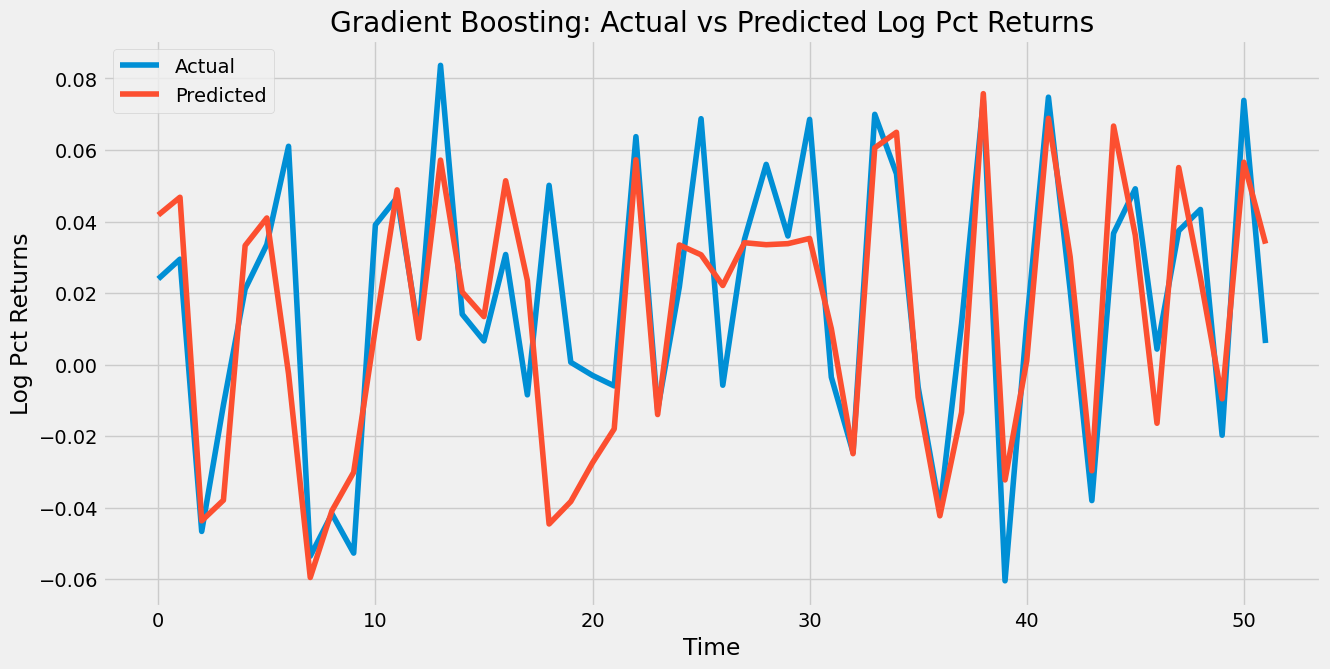

In [58]:
 # Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3'
            ]
# Define your features X and target y
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize RFE
rfe = RFE(estimator=GradientBoostingRegressor(random_state=42), n_features_to_select=39)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Fit RFE
X_rfe = rfe.fit_transform(X_scaled, y)

# Get selected features
selected_features = np.array(features)[rfe.support_]
print("Selected Features:", selected_features)

# Update features and X_scaled with selected features
features = selected_features.tolist()
X_scaled = X_rfe

# Initialize Gradient Boosting regressor
model_gb = GradientBoostingRegressor(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_gb, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=tscv, 
                           n_jobs=-1, verbose=1)

# Perform GridSearchCV to find the best model
grid_search.fit(X_scaled, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best Parameters:")
print(best_params)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    best_model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append scores to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("Gradient Boosting Results:")
print("Training MSE: {:.4f} (Std Dev: {:.4f})".format(mean_train_mse, std_train_mse))
print("Test MSE: {:.4f} (Std Dev: {:.4f})".format(mean_test_mse, std_test_mse))
print("Training RMSE: {:.4f} (Std Dev: {:.4f})".format(mean_train_rmse, std_train_rmse))
print("Test RMSE: {:.4f} (Std Dev: {:.4f})".format(mean_test_rmse, std_test_rmse))
print("Training MAE: {:.4f} (Std Dev: {:.4f})".format(mean_train_mae, std_train_mae))
print("Test MAE: {:.4f} (Std Dev: {:.4f})".format(mean_test_mae, std_test_mae))
print("Training R2: {:.4f} (Std Dev: {:.4f})".format(mean_train_r2, std_train_r2))
print("Test R2: {:.4f} (Std Dev: {:.4f})".format(mean_test_r2, std_test_r2))

# Visualize model performance
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Gradient Boosting: Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()